#**Import required libraries and tools**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

#**Download real subway dataset or generate synthetic one if unavailable**

In [2]:
print("Downloading datasets...")

url_subway = "https://raw.githubusercontent.com/datablist/sample-csv-files/main/files/people/nyc-subway-ridership.csv"

try:
    data = pd.read_csv(url_subway)
except:
    print("Using synthetic data (backup mode)")
    dates = pd.date_range(start="2024-01-01", end="2024-12-31", freq="D")
    data = pd.DataFrame({
        "date": dates,
        "day_of_week": dates.dayofweek,
        "temperature": np.random.normal(20, 8, len(dates)),
        "rainfall": np.abs(np.random.normal(2, 1, len(dates))),
    })
    data["passengers"] = (
        120000
        + data["temperature"] * 1200
        - data["rainfall"] * 2500
        - (data["day_of_week"].isin([5,6])) * 20000
        + np.random.normal(0, 5000, len(dates))
    )

if "date" not in data.columns:
    data = data.rename(columns={"Date": "date"})
if "temperature" not in data.columns:
    np.random.seed(42)
    n = len(data)
    data["temperature"] = np.random.normal(20, 8, n)
    data["rainfall"] = np.abs(np.random.normal(2, 1, n))

data["date"] = pd.to_datetime(data["date"], errors="coerce")
data["day_of_week"] = data["date"].dt.dayofweek
data = data.dropna(subset=["date"])

if "passengers" not in data.columns:
    data["passengers"] = (
        100000
        + data["temperature"] * 1500
        - data["rainfall"] * 2000
        - (data["day_of_week"].isin([5,6])) * 20000
        + np.random.normal(0, 5000, len(data))
    )

data.head()

Using synthetic data (backup mode)


,date,day_of_week,temperature,rainfall,passengers
0,2024-01-01,0,22.900549,1.431452,143119.847452
1,2024-01-02,1,30.212964,3.124305,143284.030776
2,2024-01-03,2,4.480404,2.620426,115172.878192
3,2024-01-04,3,4.091272,2.136446,124330.951040
4,2024-01-05,4,17.186877,2.175097,134940.685275


#**Prepare features and target variables, then split into train/test sets**

In [3]:
features = ["day_of_week", "temperature", "rainfall"]
X = data[features]
y = data["passengers"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

#**Train a Random Forest regression model on the training data**

In [4]:
print("Training model...")
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

Training model...


RandomForestRegressor(n_estimators=300, random_state=42)

#**Evaluate the model performance using R², RMSE, and MAE metrics**

In [5]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")

Model Performance:
R² Score: 0.8574
RMSE: 5,894
MAE: 4,678


#**Predict the number of subway passengers for the next 3 days**

In [6]:
future_dates = pd.date_range(data["date"].iloc[-1] + pd.Timedelta(days=1), periods=3)
future_data = pd.DataFrame({
    "date": future_dates,
    "day_of_week": future_dates.dayofweek,
    "temperature": np.random.normal(22, 3, 3),
    "rainfall": np.abs(np.random.normal(2, 1, 3)),
})
future_preds = model.predict(future_data[features])
future_data["predicted_passengers"] = future_preds

print("Prediction for next 3 days:")
print(future_data[["date", "predicted_passengers"]])

Prediction for next 3 days:
        date  predicted_passengers
0 2025-01-01         147499.438801
1 2025-01-02         142727.270517
2 2025-01-03         136848.134639


#**Plot actual vs predicted passenger counts on a time series chart**

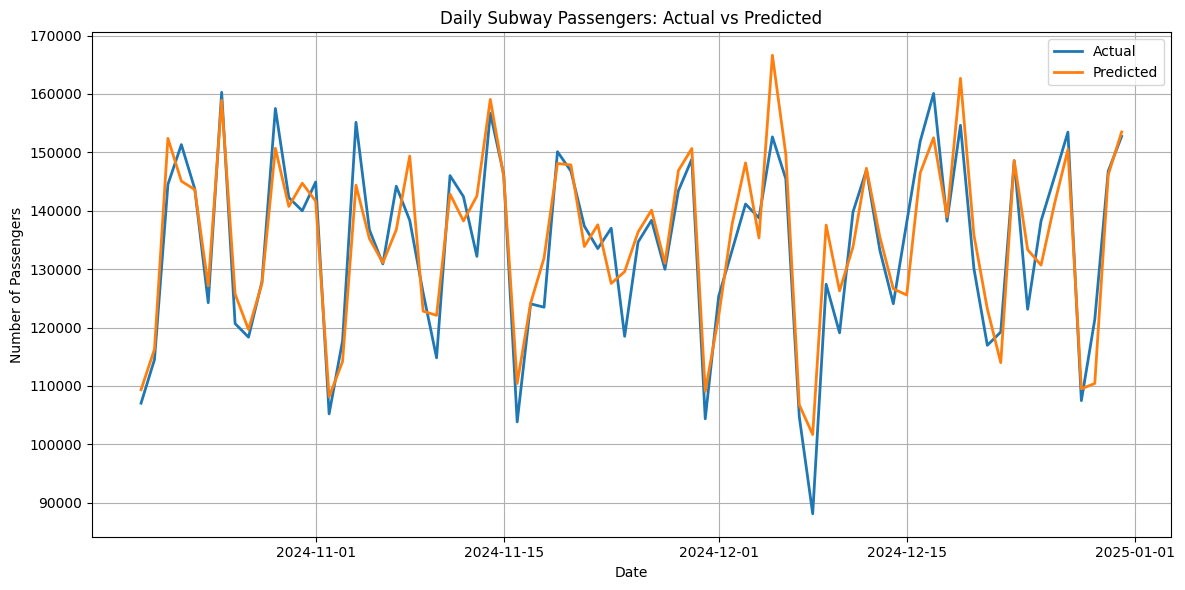

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(data["date"].iloc[-len(y_test):], y_test, label="Actual", linewidth=2)
plt.plot(data["date"].iloc[-len(y_test):], y_pred, label="Predicted", linewidth=2)
plt.title("Daily Subway Passengers: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()